## New Summarizer experiments1

What I need to do

- Retrieve the today news, article from the scrapper database.

- Summarize them with good prompt.

- display them on a UI.

In [1]:
%load_ext dotenv

In [2]:
%dotenv ./.env_prod -o

In [3]:
from src.rag.shared.database import execute_query, generate_database_connection

In [4]:
yesterday_article_query = "select content, title, posted_at,url from article where posted_at::date = CURRENT_DATE - interval '1 day'"

In [5]:
from os import getenv

In [6]:
database_user = getenv('POSTGRES_USER')
database_password = getenv('POSTGRES_PASSWORD')
database_host = getenv('POSTGRES_HOST')
database_port = getenv('POSTGRES_PORT')
database_name = getenv('POSTGRES_DB')

In [7]:
database_credentials = {
    'user': database_user,
    'password': database_password,
    'host': database_host,
    'port': database_port,
    'database': database_name
}

In [8]:
connection = generate_database_connection(database_crendentials=database_credentials)

In [9]:
connection

<connection object at 0x1071cc2e0; dsn: 'user=esp_py password=xxx dbname=congo_news_db host=107.173.6.77 port=5434', closed: 0>

In [10]:
results =execute_query(query=yesterday_article_query, database_connection=connection)

In [11]:
results[0].url

'https://actualite.cd/2024/10/09/naufrage-sur-le-lac-kivu-une-manifestation-des-familles-des-victimes-goma-pour-empecher'

In [12]:
import pandas as pd

In [13]:
results_df = pd.DataFrame.from_records(results)

In [14]:
results_df.columns = ["content", "title", "posted_at", "url"]

In [15]:
results_df.content

0     Prévue pour ce mercredi 9 octobre, l’inhumatio...
1     Le FC Renaissance a réalisé un match héroïque ...
2     En marge de la clôture de la conférence de Ham...
3     octobre 9, 2024 Crédit carbone : “La RDC ne pr...
4     octobre 9, 2024 Canada-Affaire Alexandra: Un c...
                            ...                        
75    La décision du Gouvernement de réduire les pri...
76    Dans les relations tumultueuses entre la RDC, ...
77    Après près de quatre mois passés dans les geôl...
78    L'intersyndicale des enseignants de la provinc...
79    La gestion des projets d'infrastructures Sicom...
Name: content, Length: 80, dtype: object

In [16]:
results_df = results_df.drop_duplicates(subset="content")

In [17]:
results_df.head()

,content,title,posted_at,url
0,"Prévue pour ce mercredi 9 octobre, l’inhumatio...",Naufrage sur le lac Kivu: une manifestation de...,2024-10-09 09:40:00,https://actualite.cd/2024/10/09/naufrage-sur-l...
1,Le FC Renaissance a réalisé un match héroïque ...,Ligue 1 : Renaissance arrache un nul face à Bu...,2024-10-09 18:00:00,https://actualite.cd/index.php/2024/10/09/ligu...
2,En marge de la clôture de la conférence de Ham...,Renforcement des liens africains : la Côte d'I...,2024-10-09 00:00:00,https://www.mediacongo.net/article-actualite-1...
3,"octobre 9, 2024 Crédit carbone : “La RDC ne pr...",Crédit carbone : “La RDC ne préserve pas la na...,2024-10-09 00:00:00,https://depeche.cd/2024/10/09/credit-carbone-l...
4,"octobre 9, 2024 Canada-Affaire Alexandra: Un c...",Canada-Affaire Alexandra: Un corps sans vie re...,2024-10-09 00:00:00,https://depeche.cd/2024/10/09/canada-affaire-a...


In [54]:
from src.rag.components.generator import LLamaCppGeneratorComponent

In [55]:
model_name = "Qwen/Qwen2.5-1.5B-Instruct"

In [62]:
prompt = "You are a french news reporter"

In [63]:
llama_cpp_generator = LLamaCppGeneratorComponent(
    api_url="http://127.0.0.1:8001",
    model_name=model_name,
    prompt=prompt
)

In [60]:
llama_cpp_generator._ping_api()

True

prompting doesn't seem to wokr, let us use clustering and prompting.

The step will be computing the embedding of the documents, and then cluster the document. Then for each cluster of documents, we will generate a summary.

embedding_model_id = "dunzhang/stella_en_400M_v5"

In [23]:
embedding_model_id = "dunzhang/stella_en_400M_v5"

In [24]:
from pathlib import Path

In [25]:
model_path = Path.cwd().joinpath("models")

In [26]:
embedding_model_path = model_path.joinpath(embedding_model_id)

In [27]:

transformer_kwargs = {"model_name_or_path": embedding_model_path.__str__(),
                      "trust_remote_code": True,
                      "device": "cpu",
                      "config_kwargs": {"use_memory_efficient_attention": False,
                                        "unpad_inputs": False},
                      "cache_folder": model_path}

In [28]:
from sentence_transformers import SentenceTransformer

In [29]:
sentence_transformer_model = SentenceTransformer(
    **transformer_kwargs)

Some weights of the model checkpoint at /Users/esp.py/Projects/Personal/end-to-end-rag/models/dunzhang/stella_en_400M_v5 were not used when initializing NewModel: ['new.pooler.dense.bias', 'new.pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
today_news_embeddings = sentence_transformer_model.encode(
    results_df.content.tolist())

/Users/esp.py/Projects/Personal/end-to-end-rag/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py:1141: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Not just clustering but let start with paragraph spliting and then embedding.

In [31]:
today_news_embeddings

array([[-0.55435985,  0.3149217 , -1.8363363 , ..., -0.00752111,
         0.21833092,  0.07656299],
       [-0.3725539 , -0.32037753, -1.0194424 , ..., -0.23258774,
         0.33525786, -0.67673695],
       [ 0.1559839 , -0.5912912 , -1.4163027 , ...,  0.5332099 ,
         0.23498432, -0.31350434],
       ...,
       [-0.4796751 ,  0.50040144, -1.0436513 , ...,  0.38498884,
         0.32362884,  0.16021445],
       [-0.41643924,  0.7707859 , -0.82091063, ..., -0.5980054 ,
         0.22137442,  0.13203785],
       [-0.31810996, -0.76875407, -1.014704  , ...,  0.41059893,
         0.11671694, -0.41225415]], dtype=float32)

In [32]:
today_news_embeddings.shape

(79, 1024)

In [33]:
from sklearn.cluster import KMeans

In [34]:
import matplotlib.pyplot as plt

In [35]:
axes = plt.figure(figsize=(5, 10))

<Figure size 500x1000 with 0 Axes>

In [36]:
similarities = sentence_transformer_model.similarity(today_news_embeddings, today_news_embeddings)

In [37]:
import seaborn as sb

<Axes: >

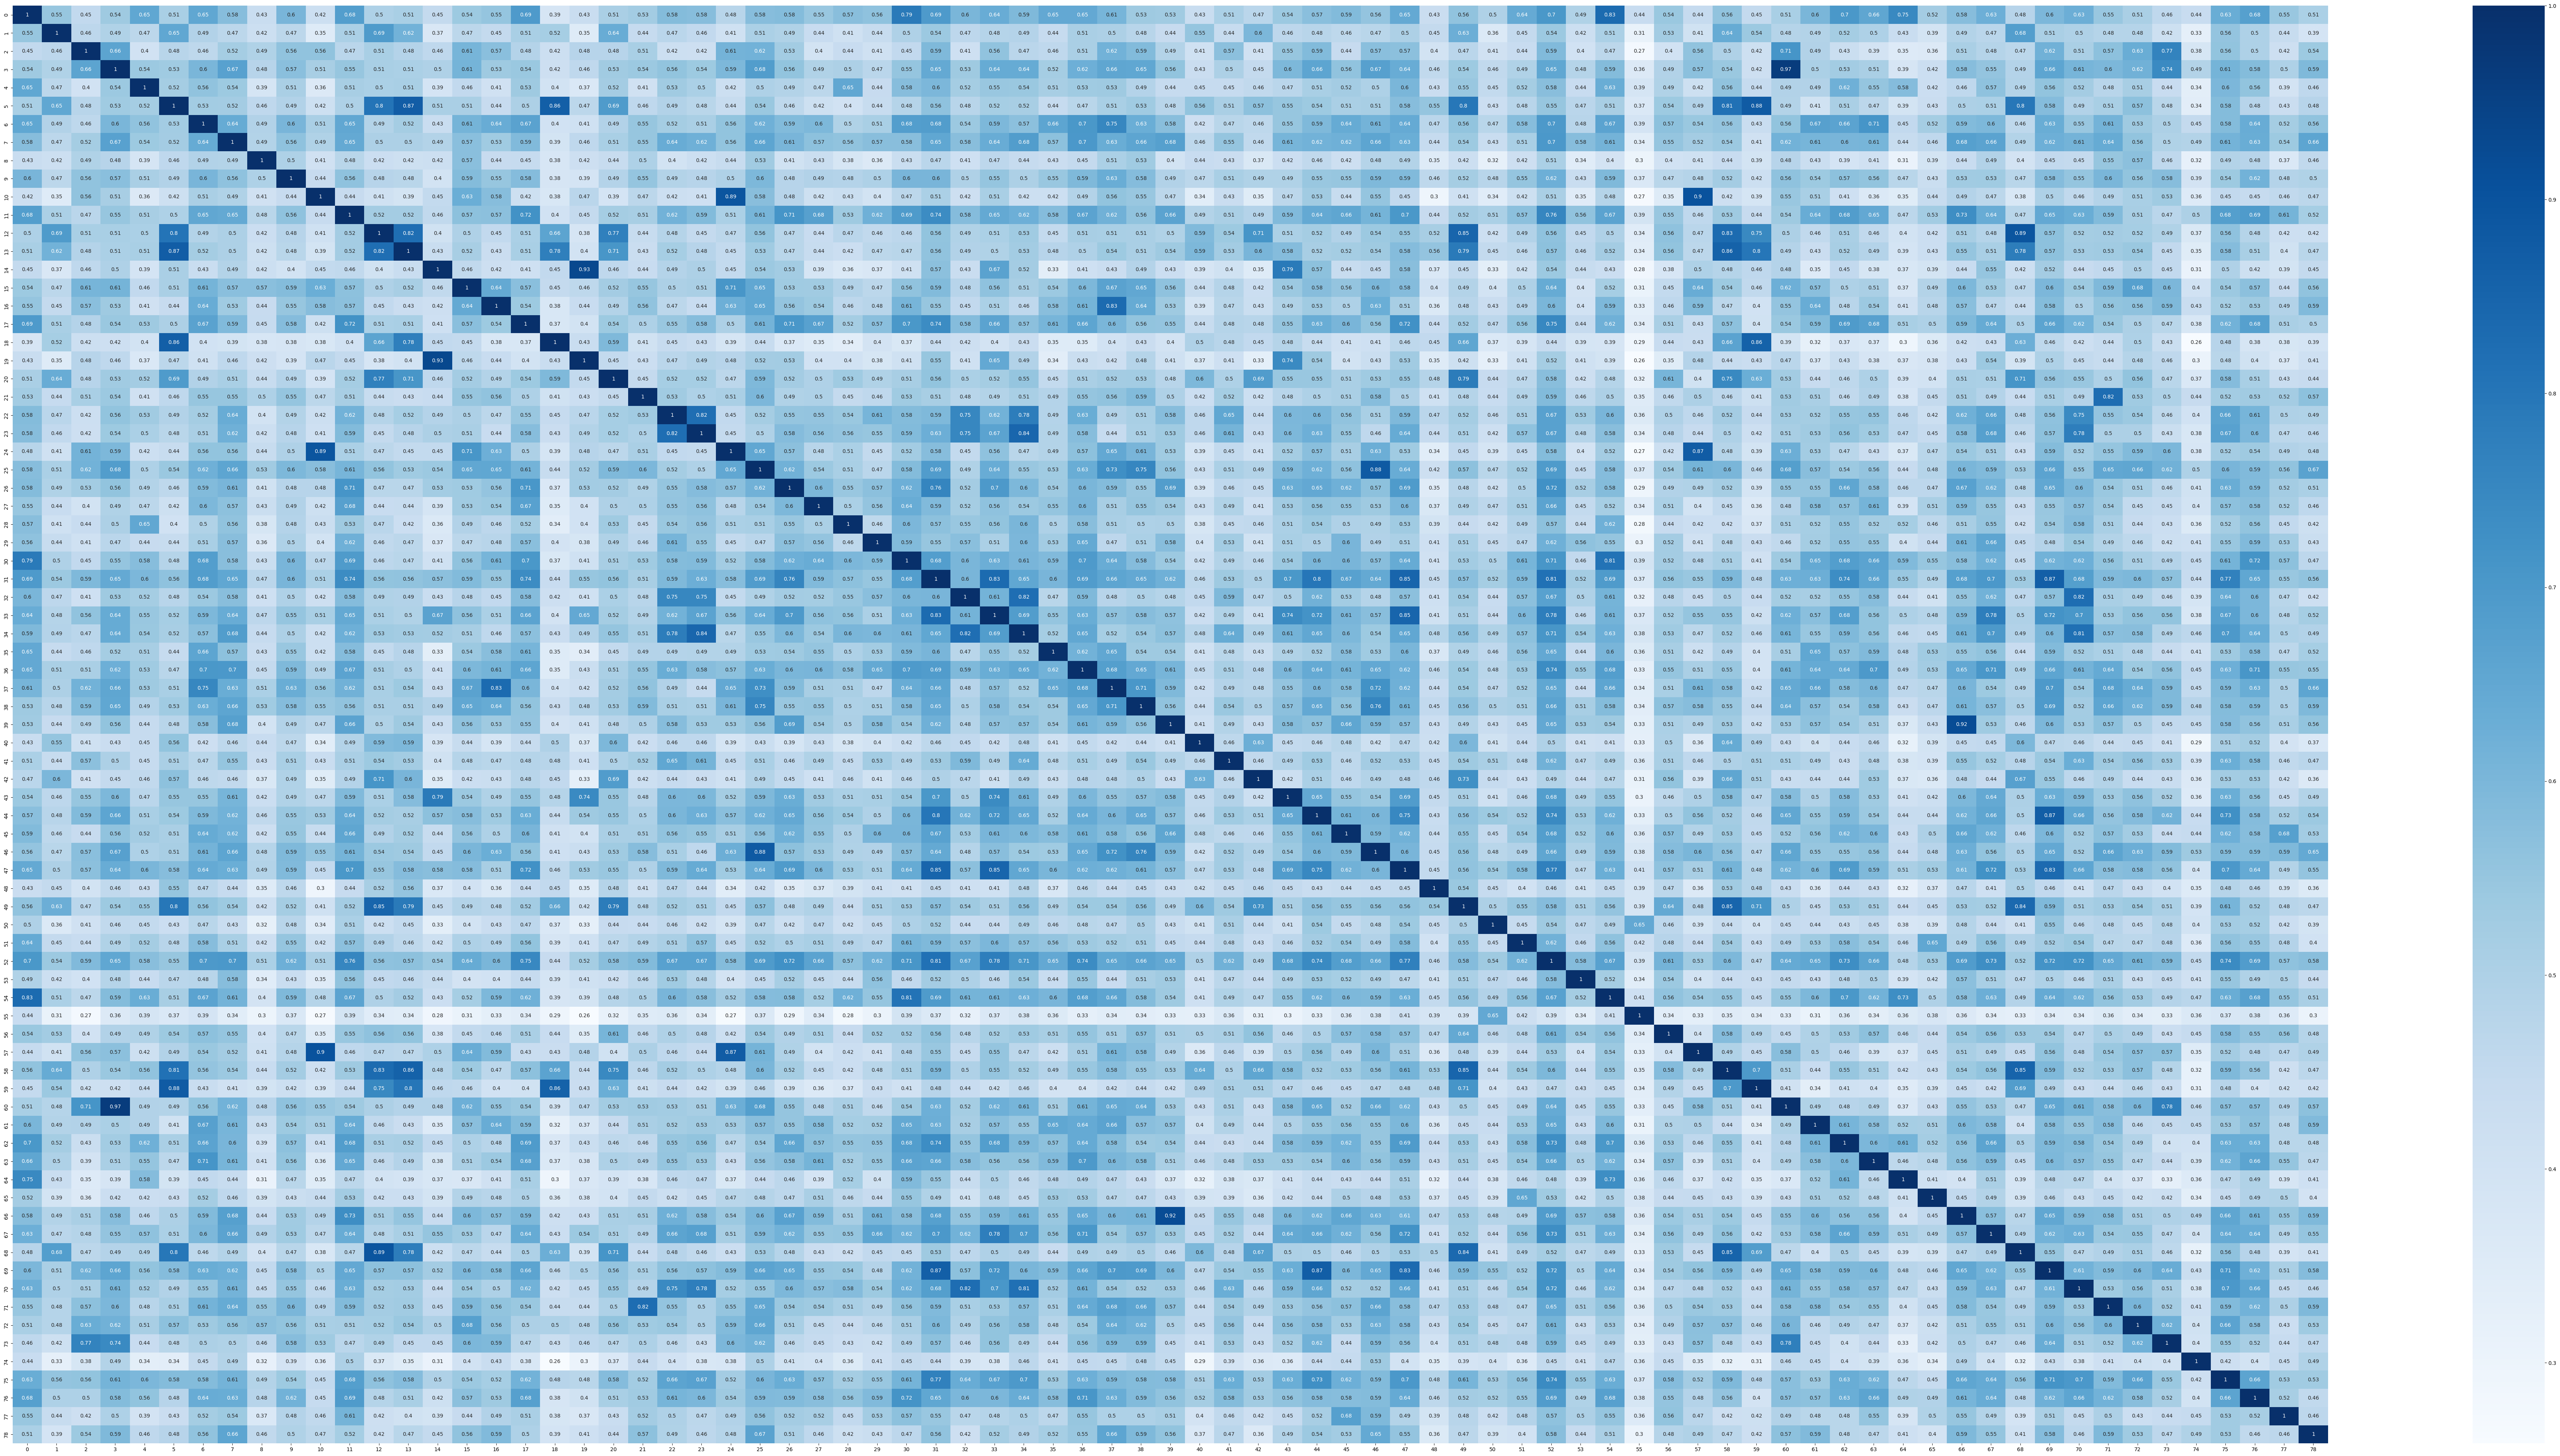

In [38]:
plt.figure(figsize=(100, 50))
sb.heatmap(similarities, cmap="Blues", annot=True)

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score

In [40]:
from sklearn.cluster import  DBSCAN

In [41]:
def find_best_estimator (X):
    K_mean_estimators = [
        (f"KMeans_{i}", KMeans(n_clusters=i, random_state=42)) for i in [ 5, 7, 10, 12]]

    best_estimator = None
    best_metric = float("-inf")
    for estimator_name, estimator in K_mean_estimators :
        estimator.fit(X)
        labels = estimator.labels_
        score = silhouette_score(
            today_news_embeddings, labels, metric="cosine")
        if score > best_metric :
            best_metric = score
            best_estimator = estimator
        print(estimator_name, score)
    return best_estimator

In [42]:
best_estimator = find_best_estimator(today_news_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


KMeans_5 0.07866426
KMeans_7 0.13135666
KMeans_10 0.13443346
KMeans_12 0.1566507


In [43]:
best_estimator

KMeans(n_clusters=12, random_state=42)

In [44]:
results_df["labels"] = best_estimator.labels_

In [45]:
results_df.query("labels ==5")

,content,title,posted_at,url,labels
7,"octobre 9, 2024 RDC-Soupçons des détournements...",RDC-Soupçons des détournements de près d’un mi...,2024-10-09 00:00:00,https://depeche.cd/2024/10/09/rdc-soupcons-des...,5
22,La dernière en date est celle de Martin Fayulu...,Procès Charles Onana : « Une tentative flagran...,2024-10-09 05:10:52,https://actu30.cd/2024/10/proces-charles-onana...,5
23,"Dans un message publié sur son compte X, le cé...","Pour Denis Mukwege, « le procès contre Charles...",2024-10-09 05:16:35,https://actu30.cd/2024/10/pour-denis-mukwege-l...,5
28,"« », a déclaré Kabongo Ngoy, soulignant l’im...",Décès d’une étudiante congolaise au Canada : l...,2024-10-09 05:32:12,https://actu30.cd/2024/10/deces-dune-etudiante...,5
32,Le procès du chercheur et journaliste cameroun...,Affaire Charles Onana : le témoignage décisif ...,2024-10-09 00:00:00,https://www.mediacongo.net/article-actualite-1...,5
34,Les poursuites judiciaires à l’encontre du pol...,Le procès Onana fait la honte de la France (Mu...,2024-10-09 00:00:00,https://www.mediacongo.net/article-actualite-1...,5
42,Impossible de dissocier l’histoire des relatio...,Robert Bourgi : «Il faut tourner le dos à la F...,2024-10-09 00:00:00,https://econewsrdc.com/robert-bourgi-il-faut-t...,5
49,Un combat pour le titre. L’International Boxin...,Bakole vs Kabayel : Jeu du trône,2024-10-09 00:00:00,https://www.mediacongo.net/article-actualite-1...,5
71,Le brillant conférencier n’a eu de cesse au co...,"Charles Onana, l’avocat ignoré",2024-10-09 00:00:00,https://econewsrdc.com/charles-onana-lavocat-i...,5
76,"Dans les relations tumultueuses entre la RDC, ...",Sommet de l’OIF : couac diplomatique sur la cr...,2024-10-09 00:00:00,https://econewsrdc.com/sommet-de-loif-couac-di...,5


In [69]:
summarization_prompt = """
Give a summary in french of the following document:
{{content}}
 Describes it in a style of a french new paper reporters.

Don't summarize each document separately, the content in all the documents should be summarized.

The summary should be in french not in English
"""

In [66]:
first_cluster = results_df.query("labels == 1")
first_cluster

,content,title,posted_at,url,labels
4,"octobre 9, 2024 Canada-Affaire Alexandra: Un c...",Canada-Affaire Alexandra: Un corps sans vie re...,2024-10-09 00:00:00,https://depeche.cd/2024/10/09/canada-affaire-a...,1
31,Devant le Conseil de sécurité des Nations-Unie...,"Est de la RDC: auprès de l'ONU, Kinshasa signa...",2024-10-09 10:00:00,https://actualite.cd/2024/10/09/est-de-la-rdc-...,1
33,La situation humanitaire alarmante dans l'est ...,Crise humanitaire dans l'est de la RDC : le ch...,2024-10-09 00:00:00,https://www.mediacongo.net/article-actualite-1...,1
45,Dans un langage assez limpide au Conseil de sé...,Conseil de sécurité de l'ONU : la RDC a mis à ...,2024-10-09 00:00:00,https://www.mediacongo.net/article-actualite-1...,1
48,La situation dans l'Est de la République démoc...,« La situation dans l’est de la RDC demeure al...,2024-10-09 00:00:00,https://www.mediacongo.net/article-actualite-1...,1
53,Un rapport documenté faisant état des violatio...,Nord-Kivu : le Président Tshisekedi informé de...,2024-10-09 00:00:00,https://www.mediacongo.net/article-actualite-1...,1
68,Les faits font écho à l’international. Mardi à...,RDC: le Haut Commissaire aux droits de l’homme...,2024-10-09 06:44:00,https://actualite.cd/index.php/2024/10/09/rdc-...,1
70,"Le processus de Luanda, principal cadre de nég...",Processus de Luanda: Kinshasa démontre la “rus...,2024-10-09 07:14:00,https://actualite.cd/index.php/2024/10/09/proc...,1


In [68]:
first_cluster.content.str.cat(sep="\n")

'octobre 9, 2024 Canada-Affaire Alexandra: Un corps sans vie repêché dans une rivière Par :    La rédaction \n \n \n Kinshasa, 08 octobre 2024 – Recherchée depuis environ une semaine maintenant, l’étudiante congolaise au Canada, Martine Alexandra serait retrouvée morte dans un parc à Trois rivières. L’information a été livrée par plusieurs personnes qui étaient descendues sur le lieu pour sa recherche. Selon les même sources, jusque là aucune confirmation de la part des autorités canadiennes s’il s’agit bel et bien de cette jeune étudiante congolaise âgée de 21 ans. Jetée dans l’eau de ce parc, c’est dans cet état que Martine Alexandra a été retrouvée dans cette rivière. Sa mère qui habite Kinshasa, capitale de la RDC, aurait déjà pris le vol pour Canada en vue de s’enquérir de la situation. Des congolais et d’autres africains vivant au Canada s’étaient mobilisés suite à la disparition de cette jeune étudiante. L’on a également noté la présence d’une délégation de l’ambassadeur de la R

In [70]:
llama_cpp_generator.generate_chat_input(
    template_values={"content": first_cluster.content.str.cat(sep="\n")}, prompt_template=summarization_prompt)

[{'role': 'system', 'content': 'You are a french news reporter'},
 {'role': 'user',
  'content': '\nGive a summary in french of the following document:\noctobre 9, 2024 Canada-Affaire Alexandra: Un corps sans vie repêché dans une rivière Par :    La rédaction \n \n \n Kinshasa, 08 octobre 2024 – Recherchée depuis environ une semaine maintenant, l’étudiante congolaise au Canada, Martine Alexandra serait retrouvée morte dans un parc à Trois rivières. L’information a été livrée par plusieurs personnes qui étaient descendues sur le lieu pour sa recherche. Selon les même sources, jusque là aucune confirmation de la part des autorités canadiennes s’il s’agit bel et bien de cette jeune étudiante congolaise âgée de 21 ans. Jetée dans l’eau de ce parc, c’est dans cet état que Martine Alexandra a été retrouvée dans cette rivière. Sa mère qui habite Kinshasa, capitale de la RDC, aurait déjà pris le vol pour Canada en vue de s’enquérir de la situation. Des congolais et d’autres africains vivant au

In [71]:
summaries = []
for id, news_group in results_df.groupby("labels"):
    news = news_group.content.str.cat(sep="\n")
    summary = llama_cpp_generator.run(template_values={"content": news}, prompt_template=summarization_prompt)
    summaries.append(summary)
    print(summary)
    print("---" * 10)

Les manifestants exigeaient la libération du président national, Jean Marc Kabund-A-Kabund, incarcéré à la prison centrale de Makala. Du côté du parti Ach, l'on dénonce une tendance du régime en place à étouffer l'opposition et promet d'autres actions dans les prochains jours pour obtenir la libération de l'ancien premier vice-président de l'Assemblée nationale. Rappelons que Jean Marc Kabund-A-Kabund a été condamné à 7 ans de prison par la Cour de cassation pour outrage au chef de l'État, aux corps constitués (Parlement et Sénat) et propagation de faux bruits.
------------------------------
La situation humanitaire dans l'Est de la République Démocratique du Congo (RDC) reste alarmante, avec des violations des droits de l'homme et une détérioration sécuritaire. Le gouvernement congolais accuse le Rwanda d'être à l'origine de ces violations, en particulier par le M23 soutenu par Kigali. L'ONU a appelé à la fin des violences et à la neutralisation des FDLR. Des efforts internationaux et

In [49]:
summarization_prompt = """
Given the following documents:
{% for summary in summaries %}
{{summary}}
{% endfor %}

Summarize them in french as a french new paper reporter. 

Find the keys topics discussed in all the documents, and summarize each topic in french.
DO NOT summarize each document separately.


The summary should be in french not in English.
"""

In [50]:
chat_input = llama_cpp_generator.generate_chat_input(
    template_values={"summaries": summaries}, prompt_template=summarization_prompt)

In [51]:
chat_input

[{'role': 'system',
  'content': 'Vous etes un redacteur des nouvelles de la presse. '},
 {'role': 'user',
  'content': '\nGiven the following documents:\n\nLes manifestants exigeaient la libération du président national, Jean Marc Kabund-A-Kabund, incarcéré à la prison centrale de Makala. Du côté du parti Ach, l\'on dénonce une tendance du régime en place à étouffer l\'opposition et promet d\'autres actions dans les prochains jours pour obtenir la libération de l\'ancien premier vice-président de l\'Assemblée nationale. Rappelons que Jean Marc Kabund-A-Kabund a été condamné à 7 ans de prison par la Cour de cassation pour outrage au chef de l\'État, aux corps constitués (Parlement et Sénat) et propagation de faux bruits.\n\nLe 8 octobre 2024, le Conseil de sécurité des Nations Unies a été tenu à Kinshasa. La ministre d\'État des Affaires étrangères Thérèse Kayikwamba a accusé le Rwanda de manipuler la situation en RDC pour diviser les communautés. Elle a également souligné que le M23 s

In [52]:
final_summary = llama_cpp_generator.run(template_values={"summaries": summaries}, prompt_template=summarization_prompt)

I will have to stop here, and then start writing about the learning. 

- Another apporach will be collect the document from radiookapi and fine tune the model.
-   Deploy the solution with streamlit

In [53]:
print(final_summary)

### Titre : La RDC et les infrastructures de colocation de données

La République Démocratique du Congo (RDC) a annoncé l'ouverture d'un centre de données de colocation, OADC Texaf - Kinshasa, qui sera le premier centre de données à accès ouvert en RDC. Ce centre de données, doté de 2MW de capacité, est certifié Uptime Institute Tier-III et a été inauguré avec la présence du président de la République, Félix-Antoine Tshisekedi Tshilombo.

Ce centre de données, qui sera situé à Kinshasa, est conçu pour répondre aux exigences croissantes des entreprises de l'Afrique centrale en matière d'infrastructures de colocation. Il sera le point de convergence pour les infrastructures de colocation de la RDC, offrant une plateforme de connectivité optimale et une sécurité renforcée.

Le centre de données OADC Texaf - Kinshasa est un investissement majeur pour l'économie numérique de la RDC. Il permettra aux institutions financières comme Sofibanque de moderniser leurs systèmes informatiques, ce qui